# PROJECT 3 

Variational Autoencoder

## Goals

- select 2 labeled datasets
- train VAE models:
     - fit the best model (topology) according to the cost function (validation set)
- explore latent space
     - generate graphics with 2D latent space projection (PCA)
     - use the labels in the projection (map that shows where the labels are)
- some questions:
     - is there formation of clusters in the latent space?
     - is there separation of labels in the latent space?
     - the projection illustrates how much of the variance?

In [199]:
import numpy as np
import pandas as pd
import random as python_random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits, load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize': (11, 6)})
random_seed = 123
python_random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
os.environ['PYTHONHASHSEED'] = str(random_seed)

<hr style="height:10px;border-width:0;background-color:red">

# DATASET DIGITS

In [200]:
dataset = load_digits()
X = dataset.data
y = dataset.target

Load the dataset and split it into training, testing, and validation. First 30% of the dataset is used for training. Then this training set is subdivided and 20% is used for validation :

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=random_seed)

In [202]:
X_tr, X_valid, y_tr, y_valid = train_test_split(X_train,
                                                y_train,
                                                test_size=0.2,
                                                random_state=random_seed)

In [203]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1257, 64), (540, 64), (1257,), (540,))

In [204]:
X_tr.shape, X_valid.shape, y_tr.shape, y_valid.shape

((1005, 64), (252, 64), (1005,), (252,))

In [205]:
np.unique(y_tr)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

`StandardScaler()` standardizes features by removing the mean and scaling to unit variance. Standardizing a dataset is a relatively common requirement for machine learning estimators as they can misbehave if individual features do not more or less resemble normally distributed standard data:

In [206]:
sc = StandardScaler()
X_tr_std = sc.fit_transform(X_tr)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)

In [207]:
train_df = pd.DataFrame(X_train)
train_df['class'] = y_train

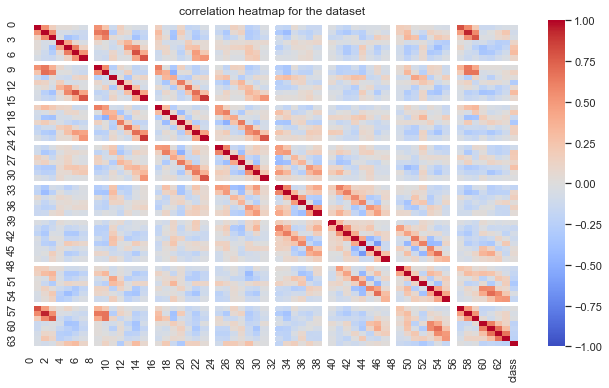

In [208]:
sns.heatmap(train_df.sample(200).corr(), vmin=-1, vmax=1, cmap="coolwarm")
# semicolon is used to avoid printing
plt.title("correlation heatmap for the dataset");

The correlation map above shows that most features are not correlated.

In [209]:
a = list(train_df.drop('class', axis=1))

In [210]:
b = train_df.drop('class', axis=1).sample(200).var()

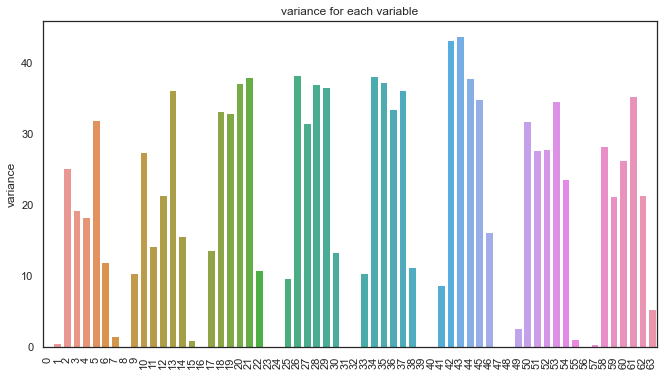

In [211]:
sns.barplot(x=a, y=b)
plt.title('variance for each variable')
plt.ylabel('variance')
plt.xticks(rotation=90);

The variance map above shows that there are many variables that are informative.

<hr style="height:10px;border-width:0;background-color:blue">

Compresses the data to 5, 10, and 30 latent dimensions:

## 5 latent dimensions

### Autoencoder

An input layer and an output layer with 64 neurons, and an intermediate layer with 5 neurons (5 latent dimensions). The number of input and output neurons (encoder-decoder) corresponds to the number of dimensions of the dataset:

In [212]:
ldim = 5
encoder = keras.models.Sequential(
    [keras.layers.Dense(ldim, input_shape=[X.shape[1]])])
decoder = keras.models.Sequential(
    [keras.layers.Dense(X.shape[1], input_shape=[ldim])])
autoencoder = keras.models.Sequential([encoder, decoder])

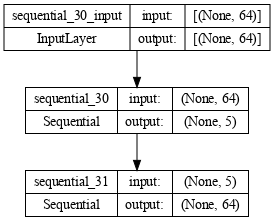

In [213]:
keras.utils.plot_model(autoencoder,
                       show_shapes=True,
                       show_layer_activations=True,
                       dpi=72)

In [214]:
autoencoder.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_30 (Sequential)  (None, 5)                 325       
                                                                 
 sequential_31 (Sequential)  (None, 64)                384       
                                                                 
Total params: 709
Trainable params: 709
Non-trainable params: 0
_________________________________________________________________


\
\
The optimizer is SGD (*gradient descent with momentum optimizer*), which has a default learning rate of 0.01. The loss function is the MSE (*mean squared error between labels and predictions*):

In [215]:
autoencoder.compile(loss='mse', optimizer="sgd")

In [216]:
history = autoencoder.fit(
    X_tr_std,
    X_tr_std,
    epochs=300,
    validation_data=(X_valid_std, X_valid_std),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/300
32/32 [==============================] - 1s 6ms/step - loss: 1.1454 - val_loss: 1.3139
Epoch 2/300
32/32 [==============================] - 0s 3ms/step - loss: 1.1074 - val_loss: 1.2749
Epoch 3/300
32/32 [==============================] - 0s 3ms/step - loss: 1.0784 - val_loss: 1.2447
Epoch 4/300
32/32 [==============================] - 0s 3ms/step - loss: 1.0554 - val_loss: 1.2210
Epoch 5/300
32/32 [==============================] - 0s 4ms/step - loss: 1.0369 - val_loss: 1.2016
Epoch 6/300
32/32 [==============================] - 0s 3ms/step - loss: 1.0214 - val_loss: 1.1853
Epoch 7/300
32/32 [==============================] - 0s 3ms/step - loss: 1.0081 - val_loss: 1.1716
Epoch 8/300
32/32 [==============================] - 0s 3ms/step - loss: 0.9968 - val_loss: 1.1598
Epoch 9/300
32/32 [==============================] - 0s 3ms/step - loss: 0.9869 - val_loss: 1.1494
Epoch 10/300
32/32 [==============================] - 0s 3ms/step - loss: 0.9779 - val_loss: 1.1399
Epoch 11/

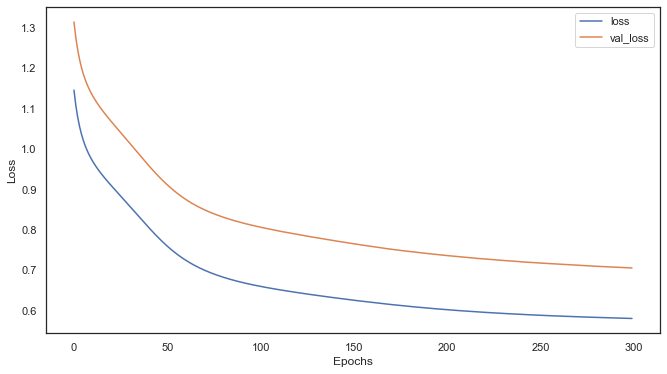

In [217]:
pd.DataFrame(history.history).plot()
plt.ylabel('Loss')
plt.xlabel('Epochs');

The learning curve graph above shows the losses during training and validation. The error during validation is relatively high (around 0.7) when compared to the error during training (around 0.6).

Prediction :

In [218]:
codings = encoder.predict(X_tr_std)

32/32 [==============================] - 0s 1ms/step


Scatter chart :

In [219]:
codings[:, 0].shape, codings[:, 1].shape

((1005,), (1005,))

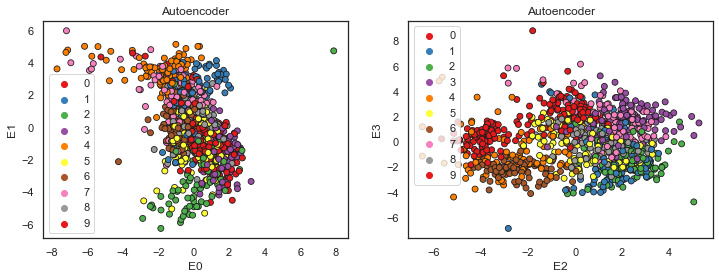

In [220]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E0")
plt.ylabel(f"E1")
plt.title(f"Autoencoder")

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 2],
                y=codings[:, 3],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E2")
plt.ylabel(f"E3")
plt.title(f"Autoencoder");

The scatterplots above show the first latent dimensions, taken from the prediction data. The graph axes are two dimensions of the prediction. It is possible to identify some clusters.

### PCA

Uses the sklearn library which does linear dimensionality reduction.

In [221]:
pca = PCA(n_components=ldim, svd_solver='auto')
scores = pca.fit_transform(X_tr_std)

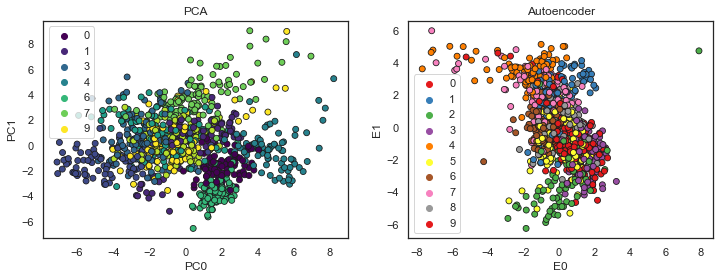

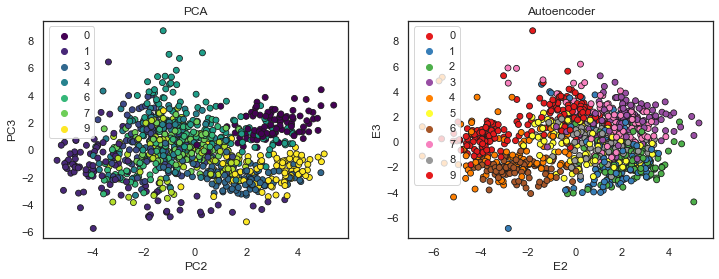

In [222]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 0],
                y=scores[:, 1],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC0')
plt.ylabel('PC1')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.xlabel('E0')
plt.ylabel('E1')
plt.title('Autoencoder')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 2],
                y=scores[:, 3],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 2],
                y=codings[:, 3],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.title('Autoencoder')
plt.xlabel('E2')
plt.ylabel('E3');

The figure above compares the PCA (left) and Autoencoder (right) algorithms. Autoencoder graphics are the same as the previous item. It is possible to observe that the two algorithms show some clusters, but most are not very well defined and overlap.

In [223]:
scores_train = pca.transform(X_tr_std)
scores_test = pca.transform(X_test_std)

codings_train = encoder.predict(X_tr_std)
codings_test = encoder.predict(X_test_std)

17/17 [==============================] - 0s 1ms/step


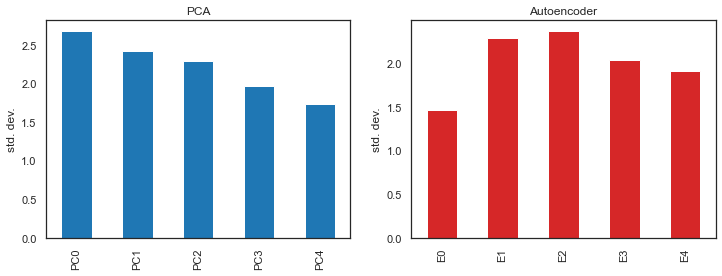

In [224]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
c = ['PC' + str(i) for i in range(pca.n_components_)]
pd.DataFrame(scores_train, columns=c).std().plot(kind='bar', color='tab:blue')
plt.title('PCA')
plt.ylabel('std. dev.')

plt.subplot(1, 2, 2)
c2 = ['E' + str(i) for i in range(ldim)]
pd.DataFrame(codings_train, columns=c2).std().plot(kind='bar', color='tab:red')
plt.title('Autoencoder')
plt.ylabel('std. dev.');

The graphs above show the standard deviation for PCA and Autoencoder. In the case of the PCA, the behavior is expected, the deviation decreases along the dimensions. In the case of the Autoencoder this behavior does not exist, the deviation is relatively uniform along the dimensions.

Correlation map:

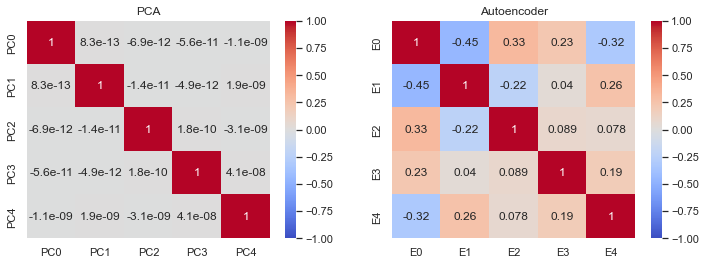

In [225]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(pd.DataFrame(scores_train,
                         columns=[
                             'PC' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('PCA')

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(codings_train,
                         columns=[
                             'E' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('Autoencoder');

The graph on the left relative to the PCA shows that the principal components (PC) are not orthogonal to each other and are not related. The graph on the right, from the Autoencoder, shows that a relationship exists and the neural network behaved as expected.

<hr style="height:10px;border-width:0;background-color:blue">

## 10 latent dimensions

### Autoencoder

Using an intermediate layer (latent dimensions) with 10 neurons:

In [226]:
ldim = 10
encoder = keras.models.Sequential(
    [keras.layers.Dense(ldim, input_shape=[X.shape[1]])])
decoder = keras.models.Sequential(
    [keras.layers.Dense(X.shape[1], input_shape=[ldim])])
autoencoder = keras.models.Sequential([encoder, decoder])

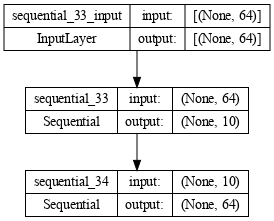

In [227]:
keras.utils.plot_model(autoencoder,
                       show_shapes=True,
                       show_layer_activations=True,
                       dpi=72)

In [228]:
autoencoder.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_33 (Sequential)  (None, 10)                650       
                                                                 
 sequential_34 (Sequential)  (None, 64)                704       
                                                                 
Total params: 1,354
Trainable params: 1,354
Non-trainable params: 0
_________________________________________________________________


In [229]:
autoencoder.compile(loss='mse', optimizer="sgd")

In [230]:
history = autoencoder.fit(
    X_tr_std,
    X_tr_std,
    epochs=300,
    validation_data=(X_valid_std, X_valid_std),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/300
32/32 [==============================] - 0s 6ms/step - loss: 1.3597 - val_loss: 1.5794
Epoch 2/300
32/32 [==============================] - 0s 3ms/step - loss: 1.2781 - val_loss: 1.4929
Epoch 3/300
32/32 [==============================] - 0s 4ms/step - loss: 1.2162 - val_loss: 1.4260
Epoch 4/300
32/32 [==============================] - 0s 3ms/step - loss: 1.1673 - val_loss: 1.3727
Epoch 5/300
32/32 [==============================] - 0s 3ms/step - loss: 1.1278 - val_loss: 1.3291
Epoch 6/300
32/32 [==============================] - 0s 3ms/step - loss: 1.0949 - val_loss: 1.2921
Epoch 7/300
32/32 [==============================] - 0s 3ms/step - loss: 1.0669 - val_loss: 1.2610
Epoch 8/300
32/32 [==============================] - 0s 3ms/step - loss: 1.0429 - val_loss: 1.2339
Epoch 9/300
32/32 [==============================] - 0s 3ms/step - loss: 1.0219 - val_loss: 1.2101
Epoch 10/300
32/32 [==============================] - 0s 3ms/step - loss: 1.0031 - val_loss: 1.1887
Epoch 11/

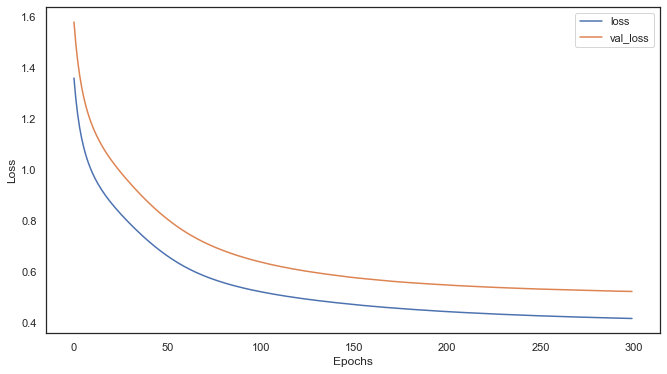

In [231]:
pd.DataFrame(history.history).plot()
plt.ylabel('Loss')
plt.xlabel('Epochs');

The learning curve graph above, when compared to the previous item with 5 neurons in the intermediate layer, presents smaller losses, reducing the validation loss of approx. 0.7 to 0.6.

In [232]:
codings = encoder.predict(X_tr_std)

32/32 [==============================] - 0s 904us/step


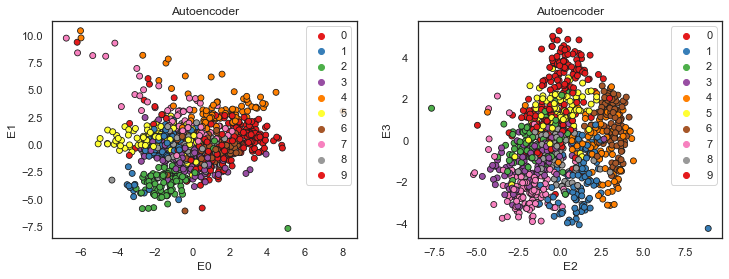

In [233]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E0")
plt.ylabel(f"E1")
plt.title(f"Autoencoder")

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 2],
                y=codings[:, 3],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E2")
plt.ylabel(f"E3")
plt.title(f"Autoencoder");

The scatterplots above, when compared to the previous section (5 neurons in the middle layer) show clusters with a little better definition, for example the label "5" (yellow) is forming a better defined cluster.

### PCA

In [234]:
pca = PCA(n_components=ldim, svd_solver='auto')
scores = pca.fit_transform(X_tr_std)

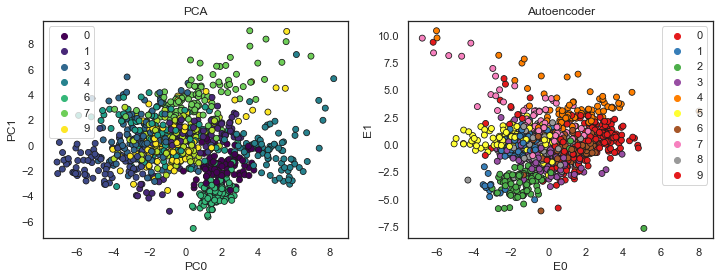

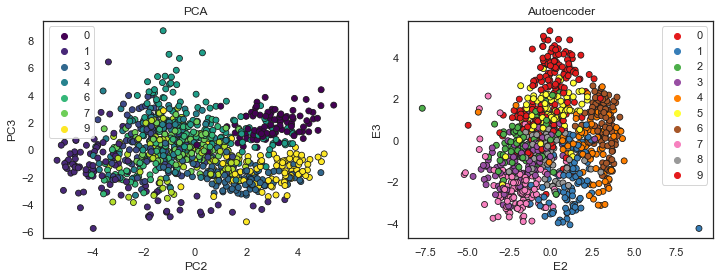

In [235]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 0],
                y=scores[:, 1],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC0')
plt.ylabel('PC1')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.xlabel('E0')
plt.ylabel('E1')
plt.title('Autoencoder')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 2],
                y=scores[:, 3],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 2],
                y=codings[:, 3],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.title('Autoencoder')
plt.xlabel('E2')
plt.ylabel('E3');

The figure above compares the PCA (left) and Autoencoder (right) algorithms. Autoencoder graphics are the same as the previous item. The PCA graphics are similar to those of the previous item with 5 layers (latent dimensions), there was no variation.

In [236]:
scores_train = pca.transform(X_tr_std)
scores_test = pca.transform(X_test_std)

codings_train = encoder.predict(X_tr_std)
codings_test = encoder.predict(X_test_std)

17/17 [==============================] - 0s 1ms/step


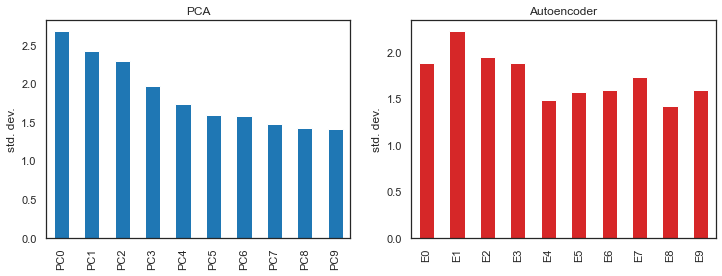

In [237]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
c = ['PC' + str(i) for i in range(ldim)]
pd.DataFrame(scores_train, columns=c).std().plot(kind='bar', color='tab:blue')
plt.title('PCA')
plt.ylabel('std. dev.')

plt.subplot(1, 2, 2)
c2 = ['E' + str(i) for i in range(ldim)]
pd.DataFrame(codings_train, columns=c2).std().plot(kind='bar', color='tab:red')
plt.title('Autoencoder')
plt.ylabel('std. dev.');

The graphs above show the standard deviation for PCA and Autoencoder. In the case of the PCA, the behavior is expected, the deviation decreases along the dimensions. However, in the case of the Autoencoder, this behavior does not exist, the deviation is relatively uniform along the dimensions.

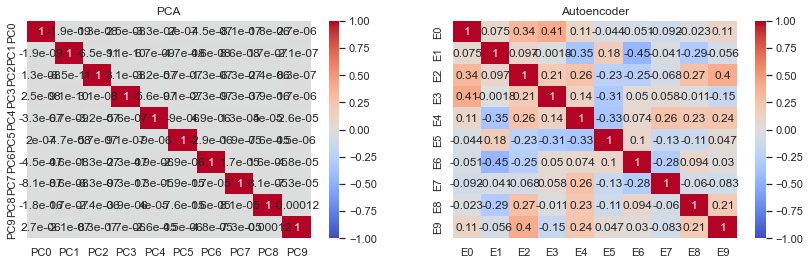

In [238]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.heatmap(pd.DataFrame(scores_train,
                         columns=[
                             'PC' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('PCA')

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(codings_train,
                         columns=[
                             'E' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('Autoencoder');

The graph on the left relative to the PCA shows that the principal components (PC) are not orthogonal to each other and are not related. The graph on the right, from the Autoencoder, shows that there is a relationship between the components, the neural network behaved as expected.

<hr style="height:10px;border-width:0;background-color:blue">

## 30 latent dimensions

### Autoencoder

An input layer and an output layer with 64 neurons, and an intermediate layer with 30 neurons. The number of input and output neurons (encoder-decoder) corresponds to the number of dimensions of the dataset:

In [239]:
ldim = 30
encoder = keras.models.Sequential(
    [keras.layers.Dense(ldim, input_shape=[X.shape[1]])])
decoder = keras.models.Sequential(
    [keras.layers.Dense(X.shape[1], input_shape=[ldim])])
autoencoder = keras.models.Sequential([encoder, decoder])

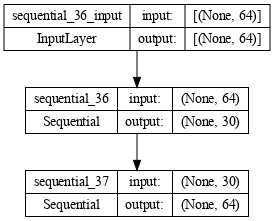

In [240]:
keras.utils.plot_model(autoencoder,
                       show_shapes=True,
                       show_layer_activations=True,
                       dpi=72)

In [241]:
autoencoder.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_36 (Sequential)  (None, 30)                1950      
                                                                 
 sequential_37 (Sequential)  (None, 64)                1984      
                                                                 
Total params: 3,934
Trainable params: 3,934
Non-trainable params: 0
_________________________________________________________________


In [242]:
autoencoder.compile(loss='mse', optimizer="sgd")

In [243]:
history = autoencoder.fit(
    X_tr_std,
    X_tr_std,
    epochs=300,
    validation_data=(X_valid_std, X_valid_std),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/300
32/32 [==============================] - 1s 12ms/step - loss: 1.7423 - val_loss: 1.9202
Epoch 2/300
32/32 [==============================] - 0s 3ms/step - loss: 1.5680 - val_loss: 1.7568
Epoch 3/300
32/32 [==============================] - 0s 3ms/step - loss: 1.4390 - val_loss: 1.6316
Epoch 4/300
32/32 [==============================] - 0s 3ms/step - loss: 1.3381 - val_loss: 1.5316
Epoch 5/300
32/32 [==============================] - 0s 3ms/step - loss: 1.2566 - val_loss: 1.4495
Epoch 6/300
32/32 [==============================] - 0s 3ms/step - loss: 1.1886 - val_loss: 1.3791
Epoch 7/300
32/32 [==============================] - 0s 3ms/step - loss: 1.1301 - val_loss: 1.3194
Epoch 8/300
32/32 [==============================] - 0s 3ms/step - loss: 1.0800 - val_loss: 1.2674
Epoch 9/300
32/32 [==============================] - 0s 3ms/step - loss: 1.0360 - val_loss: 1.2211
Epoch 10/300
32/32 [==============================] - 0s 3ms/step - loss: 0.9966 - val_loss: 1.1796
Epoch 11

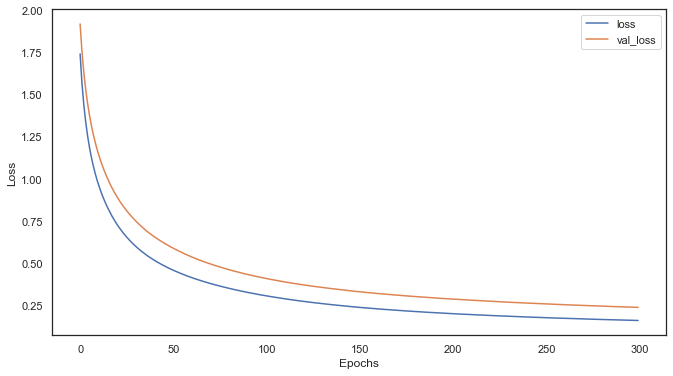

In [244]:
pd.DataFrame(history.history).plot()
plt.ylabel('Loss')
plt.xlabel('Epochs');

The learning curve graph above shows the losses during training and validation. The error during validation greatly reduced with respect to 5 and 10 neurons in the intermediate layer, it dropped from 0.7 to about 0.3.

Prediction :

In [245]:
codings = encoder.predict(X_tr_std)

32/32 [==============================] - 0s 910us/step


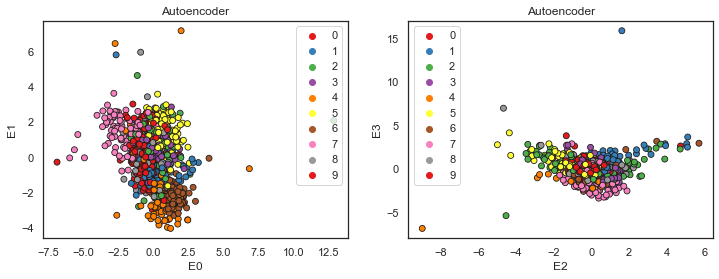

In [246]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E0")
plt.ylabel(f"E1")
plt.title(f"Autoencoder")

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 2],
                y=codings[:, 3],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E2")
plt.ylabel(f"E3")
plt.title(f"Autoencoder");

The scatterplots above show the first latent dimensions, taken from the prediction data. The graph axes are two dimensions of the prediction. With regard to the previous item (5 neurons in the intermediate layer), the identification of clusters worsened because the clusters became more united, closer, especially in the figure on the right.

### PCA

In [247]:
pca = PCA(n_components=ldim, svd_solver='auto')
scores = pca.fit_transform(X_tr_std)

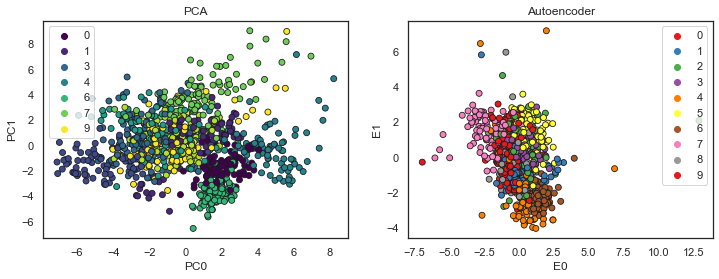

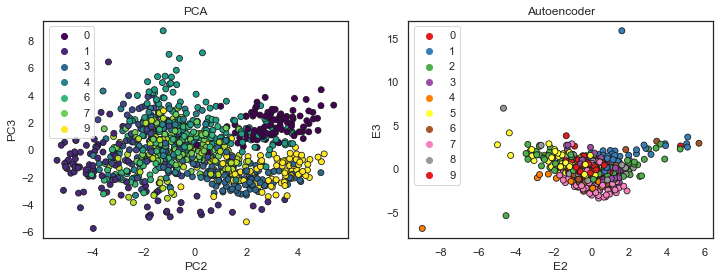

In [248]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 0],
                y=scores[:, 1],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC0')
plt.ylabel('PC1')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.xlabel('E0')
plt.ylabel('E1')
plt.title('Autoencoder')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 2],
                y=scores[:, 3],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 2],
                y=codings[:, 3],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.title('Autoencoder')
plt.xlabel('E2')
plt.ylabel('E3');

The figure above compares the PCA (left) and Autoencoder (right) algorithms. Autoencoder graphics are the same as the previous item. The PCA graphics are similar to those of the previous item with 10 layers (latent dimensions), there was no variation.

In [249]:
scores_train = pca.transform(X_tr_std)
scores_test = pca.transform(X_test_std)

codings_train = encoder.predict(X_tr_std)
codings_test = encoder.predict(X_test_std)

17/17 [==============================] - 0s 1ms/step


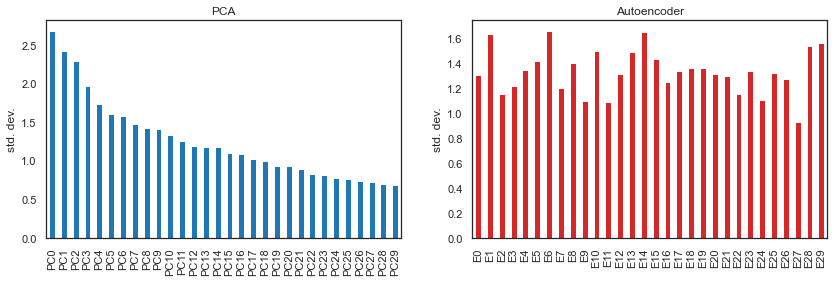

In [250]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
c = ['PC' + str(i) for i in range(ldim)]
pd.DataFrame(scores_train, columns=c).std().plot(kind='bar', color='tab:blue')
plt.title('PCA')
plt.ylabel('std. dev.')

plt.subplot(1, 2, 2)
c2 = ['E' + str(i) for i in range(ldim)]
pd.DataFrame(codings_train, columns=c2).std().plot(kind='bar', color='tab:red')
plt.title('Autoencoder')
plt.ylabel('std. dev.');

The graphs above show the standard deviation for PCA and Autoencoder. In the case of the PCA, the behavior is expected, the deviation decreases along the dimensions. However, in the case of the Autoencoder, this behavior does not exist, the deviation is relatively uniform along the dimensions.

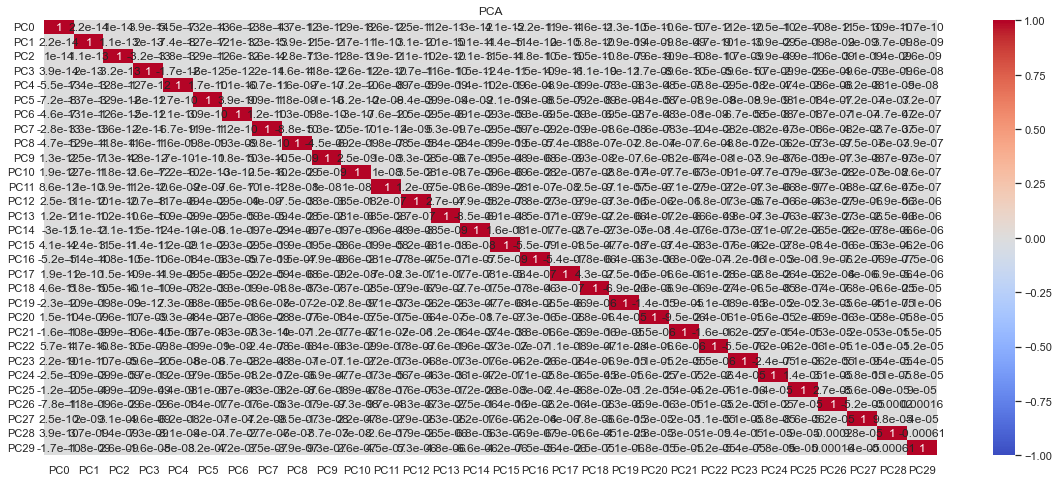

In [251]:
sns.set(style='white', context='notebook', rc={'figure.figsize': (20, 8)})
sns.heatmap(pd.DataFrame(scores_train,
                         columns=[
                             'PC' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('PCA');

The plot relative to the PCA shows that the principal components (PC) are not orthogonal to each other and are not related.

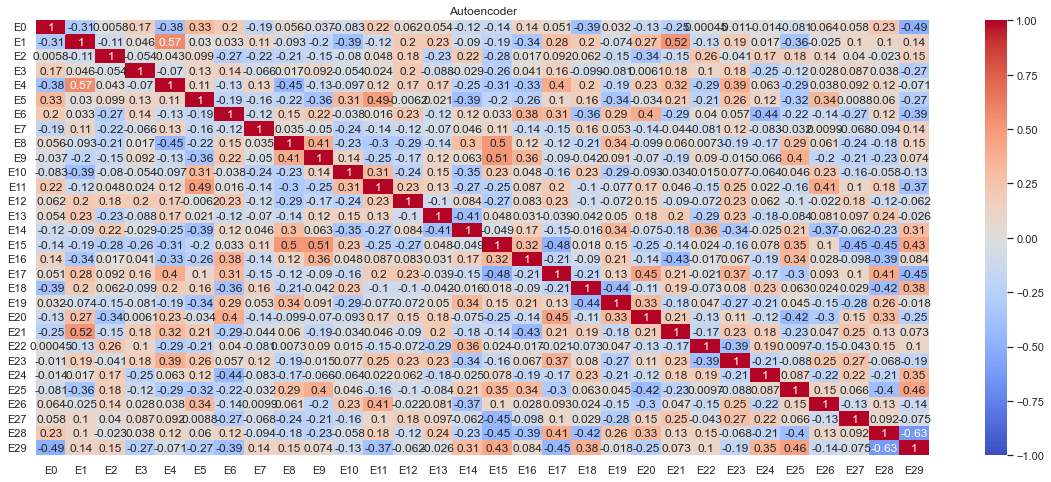

In [252]:
sns.heatmap(pd.DataFrame(codings_train,
                         columns=[
                             'E' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('Autoencoder');

The Autoencoder graph shows that there is a relationship between the components, the neural network behaved as expected.

<hr style="height:10px;border-width:0;background-color:red">

# DATASET WINE

The Wine dataset contains the results of a chemical analysis of wines grown in the same region of Italy by three different growers. There are thirteen different measures for different constituents found in the three types of wine (13 dimensions and 3 classes).

In [253]:
dataset = load_wine()
X = dataset.data
y = dataset.target
samples = 99

In [254]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=random_seed)
X_tr, X_valid, y_tr, y_valid = train_test_split(X_train,
                                                y_train,
                                                test_size=0.2,
                                                random_state=random_seed)

In [255]:
X_tr.shape, X_valid.shape, X_test.shape

((99, 13), (25, 13), (54, 13))

In [256]:
np.unique(y_tr)

array([0, 1, 2])

In [257]:
sc = StandardScaler()
X_tr_std = sc.fit_transform(X_tr)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)

In [258]:
train_df = pd.DataFrame(X_train)
train_df['class'] = y_train

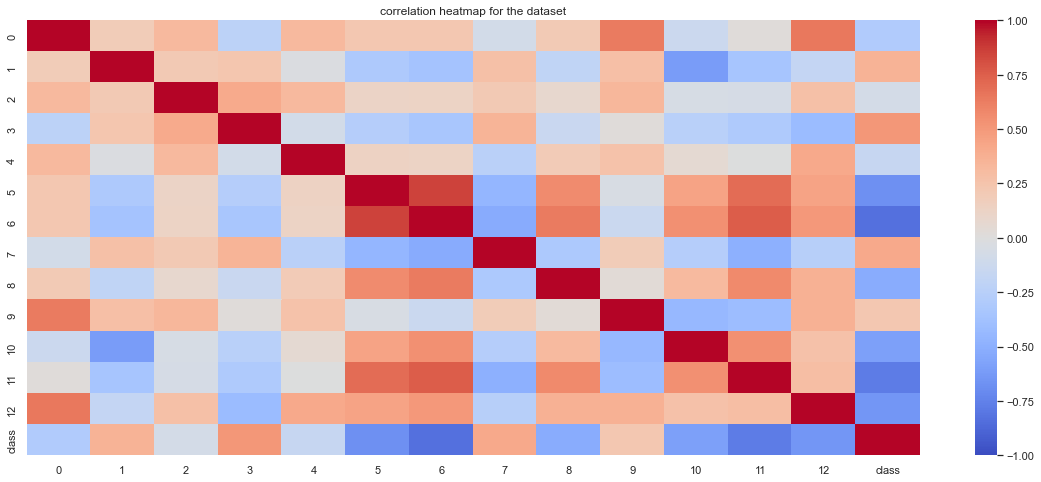

In [259]:
sns.heatmap(train_df.sample(samples).corr(), vmin=-1, vmax=1, cmap="coolwarm")
# semicolon is used to avoid printing
plt.title("correlation heatmap for the dataset");

The correlation map above shows that most features are not correlated.

In [260]:
a = list(train_df.drop('class', axis=1))

In [261]:
b = train_df.drop('class', axis=1).sample(samples).var()

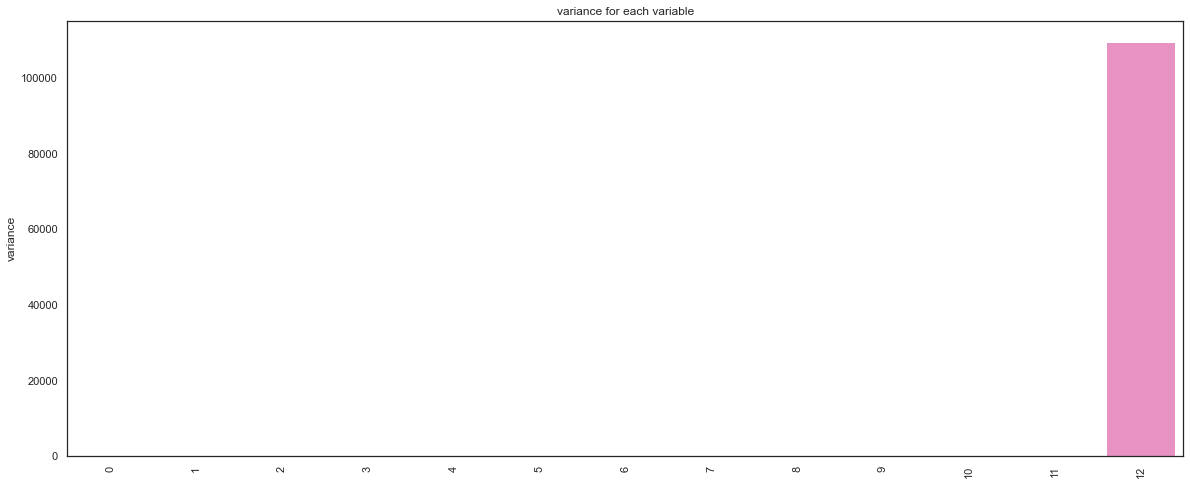

In [262]:
sns.barplot(x=a, y=b)
plt.title('variance for each variable')
plt.ylabel('variance')
plt.xticks(rotation=90);

The variance map above shows that there is a single informative variable.

<hr style="height:10px;border-width:0;background-color:blue">

Compress the data to 3, 6, and 9 latent dimensions :

## 3 latent dimensions

### Autoencoder

An input layer and an output layer with 13 neurons, and an intermediate layer with 3 neurons (3 latent dimensions). The number of input and output neurons (encoder-decoder) corresponds to the number of dimensions of the dataset :

In [263]:
ldim = 3
encoder = keras.models.Sequential(
    [keras.layers.Dense(ldim, input_shape=[X.shape[1]])])
decoder = keras.models.Sequential(
    [keras.layers.Dense(X.shape[1], input_shape=[ldim])])
autoencoder = keras.models.Sequential([encoder, decoder])

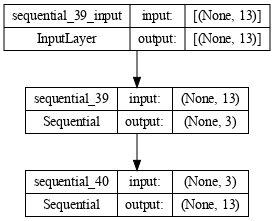

In [264]:
keras.utils.plot_model(autoencoder,
                       show_shapes=True,
                       show_layer_activations=True,
                       dpi=72)

In [265]:
autoencoder.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_39 (Sequential)  (None, 3)                 42        
                                                                 
 sequential_40 (Sequential)  (None, 13)                52        
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [266]:
autoencoder.compile(loss='mse', optimizer="sgd")

In [267]:
history = autoencoder.fit(
    X_tr_std,
    X_tr_std,
    epochs=300,
    validation_data=(X_valid_std, X_valid_std),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/300
4/4 [==============================] - 0s 37ms/step - loss: 1.6363 - val_loss: 1.3680
Epoch 2/300
4/4 [==============================] - 0s 13ms/step - loss: 1.5817 - val_loss: 1.3391
Epoch 3/300
4/4 [==============================] - 0s 13ms/step - loss: 1.5379 - val_loss: 1.3157
Epoch 4/300
4/4 [==============================] - 0s 11ms/step - loss: 1.5006 - val_loss: 1.2939
Epoch 5/300
4/4 [==============================] - 0s 14ms/step - loss: 1.4660 - val_loss: 1.2762
Epoch 6/300
4/4 [==============================] - 0s 12ms/step - loss: 1.4377 - val_loss: 1.2598
Epoch 7/300
4/4 [==============================] - 0s 10ms/step - loss: 1.4126 - val_loss: 1.2418
Epoch 8/300
4/4 [==============================] - 0s 10ms/step - loss: 1.3801 - val_loss: 1.2238
Epoch 9/300
4/4 [==============================] - 0s 10ms/step - loss: 1.3533 - val_loss: 1.2106
Epoch 10/300
4/4 [==============================] - 0s 10ms/step - loss: 1.3323 - val_loss: 1.1977
Epoch 11/300
4/4 [=

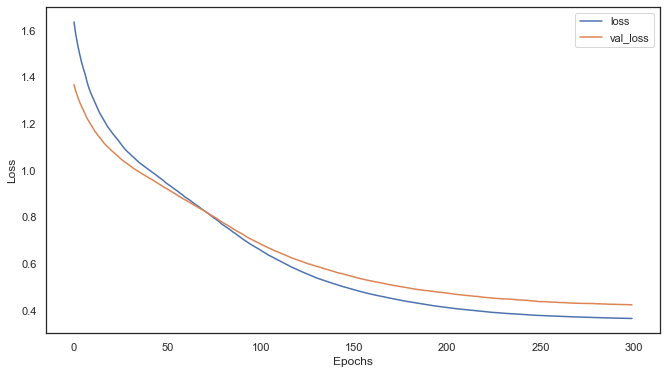

In [268]:
sns.set(style='white', context='notebook', rc={'figure.figsize': (11, 6)})
pd.DataFrame(history.history).plot()
plt.ylabel('Loss')
plt.xlabel('Epochs');

The learning curve graph above shows the losses during training and validation. The error during validation closely follows the error during training (around 0.4 for 300 epochs).

Predição:

In [269]:
codings = encoder.predict(X_tr_std)

4/4 [==============================] - 0s 1ms/step


Scatter chart :

In [270]:
codings[:, 0].shape, codings[:, 1].shape

((99,), (99,))

In [271]:
np.unique(y_tr)

array([0, 1, 2])

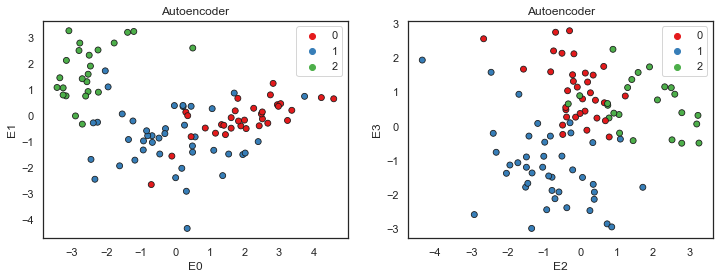

In [272]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E0")
plt.ylabel(f"E1")
plt.title(f"Autoencoder")

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 1],
                y=codings[:, 2],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E2")
plt.ylabel(f"E3")
plt.title(f"Autoencoder");

The scatterplots above show the first latent dimensions, taken from the prediction data. The graph axes are two dimensions of the prediction. Compared to the same graphs from the DIGITS dataset, these graphs are more spaced and the clusters are clearly visible, for example in the left graph the label "2" is clearly visible in green in the upper left corner.

### PCA

In [273]:
pca = PCA(n_components=ldim, svd_solver='auto')
scores = pca.fit_transform(X_tr_std)

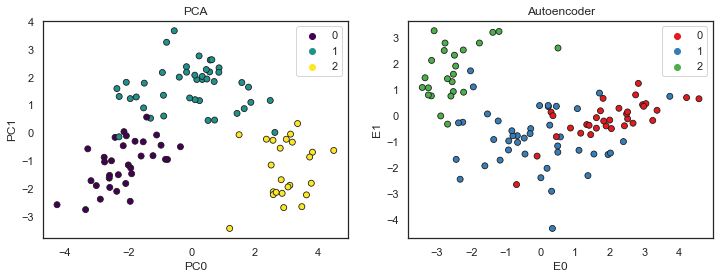

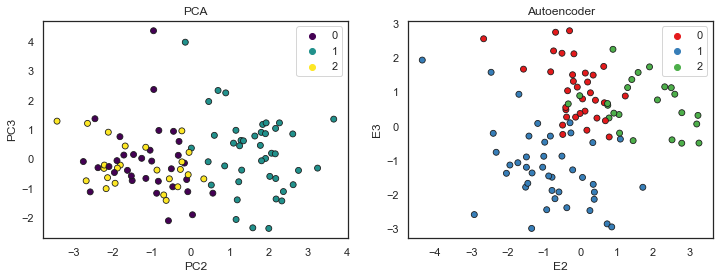

In [274]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 0],
                y=scores[:, 1],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC0')
plt.ylabel('PC1')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.xlabel('E0')
plt.ylabel('E1')
plt.title('Autoencoder')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 1],
                y=scores[:, 2],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 1],
                y=codings[:, 2],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.title('Autoencoder')
plt.xlabel('E2')
plt.ylabel('E3');

The figure above compares the PCA (left) and Autoencoder (right) algorithms. Autoencoder graphics are the same as the previous item. It is possible to observe that both algorithms show well-defined clusters.

In [275]:
scores_train = pca.transform(X_tr_std)
scores_test = pca.transform(X_test_std)

codings_train = encoder.predict(X_tr_std)
codings_test = encoder.predict(X_test_std)

2/2 [==============================] - 0s 2ms/step


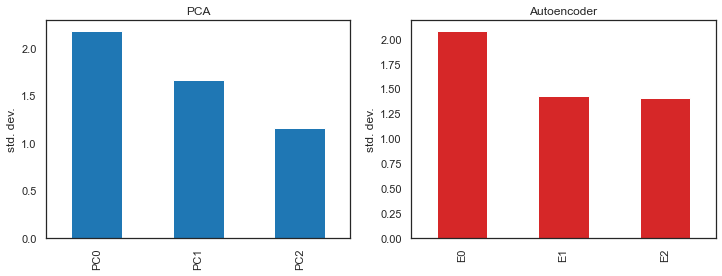

In [276]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
c = ['PC' + str(i) for i in range(pca.n_components_)]
pd.DataFrame(scores_train, columns=c).std().plot(kind='bar', color='tab:blue')
plt.title('PCA')
plt.ylabel('std. dev.')

plt.subplot(1, 2, 2)
c2 = ['E' + str(i) for i in range(ldim)]
pd.DataFrame(codings_train, columns=c2).std().plot(kind='bar', color='tab:red')
plt.title('Autoencoder')
plt.ylabel('std. dev.');

The graphs above show the standard deviation for PCA and Autoencoder. In the case of the PCA, the behavior is expected, the deviation decreases along the dimensions. In the case of the Autoencoder, this behavior also happened for the first two dimensions, but the third dimension remained the same as the previous one.

Correlation map:

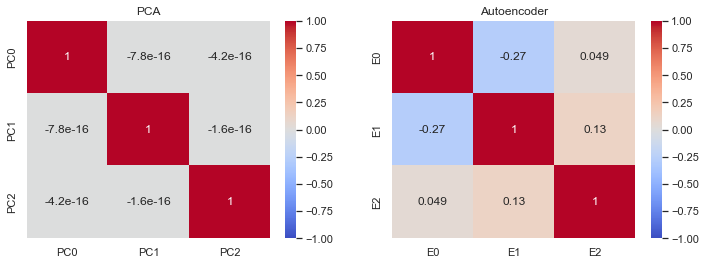

In [277]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(pd.DataFrame(scores_train,
                         columns=[
                             'PC' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('PCA')

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(codings_train,
                         columns=[
                             'E' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('Autoencoder');

The graph on the left relative to the PCA shows that the principal components (PC) are not orthogonal to each other and are not related. The graph on the right, from the Autoencoder, shows that there is a relationship and the neural network behaved as expected.

<hr style="height:10px;border-width:0;background-color:blue">

## 6 latent dimensions

### Autoencoder

In [278]:
ldim = 6
encoder = keras.models.Sequential(
    [keras.layers.Dense(ldim, input_shape=[X.shape[1]])])
decoder = keras.models.Sequential(
    [keras.layers.Dense(X.shape[1], input_shape=[ldim])])
autoencoder = keras.models.Sequential([encoder, decoder])

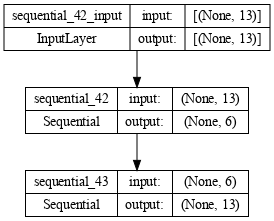

In [279]:
keras.utils.plot_model(autoencoder,
                       show_shapes=True,
                       show_layer_activations=True,
                       dpi=72)

In [280]:
autoencoder.summary()

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_42 (Sequential)  (None, 6)                 84        
                                                                 
 sequential_43 (Sequential)  (None, 13)                91        
                                                                 
Total params: 175
Trainable params: 175
Non-trainable params: 0
_________________________________________________________________


In [281]:
autoencoder.compile(loss='mse', optimizer="sgd")

In [282]:
history = autoencoder.fit(
    X_tr_std,
    X_tr_std,
    epochs=300,
    validation_data=(X_valid_std, X_valid_std),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/300
4/4 [==============================] - 0s 38ms/step - loss: 1.8813 - val_loss: 1.5785
Epoch 2/300
4/4 [==============================] - 0s 10ms/step - loss: 1.7737 - val_loss: 1.4943
Epoch 3/300
4/4 [==============================] - 0s 15ms/step - loss: 1.6726 - val_loss: 1.4329
Epoch 4/300
4/4 [==============================] - 0s 15ms/step - loss: 1.5964 - val_loss: 1.3744
Epoch 5/300
4/4 [==============================] - 0s 14ms/step - loss: 1.5213 - val_loss: 1.3320
Epoch 6/300
4/4 [==============================] - 0s 11ms/step - loss: 1.4686 - val_loss: 1.2935
Epoch 7/300
4/4 [==============================] - 0s 11ms/step - loss: 1.4207 - val_loss: 1.2542
Epoch 8/300
4/4 [==============================] - 0s 10ms/step - loss: 1.3648 - val_loss: 1.2119
Epoch 9/300
4/4 [==============================] - 0s 9ms/step - loss: 1.3102 - val_loss: 1.1804
Epoch 10/300
4/4 [==============================] - 0s 11ms/step - loss: 1.2704 - val_loss: 1.1508
Epoch 11/300
4/4 [==

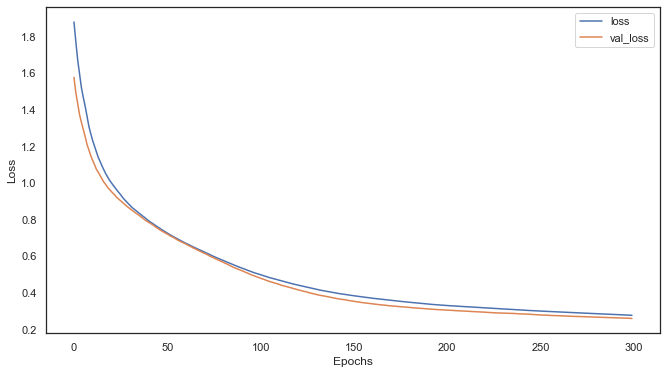

In [283]:
pd.DataFrame(history.history).plot()
plt.ylabel('Loss')
plt.xlabel('Epochs');

The learning curve graph above shows that the training and validation loss curves are close, coming in at approx. 0.3 with 300 epochs.

In [284]:
codings = encoder.predict(X_tr_std)

4/4 [==============================] - 0s 1ms/step


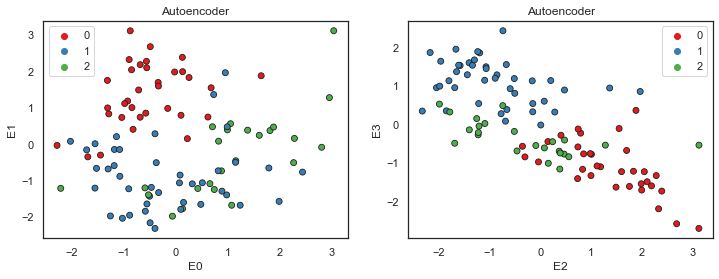

In [285]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E0")
plt.ylabel(f"E1")
plt.title(f"Autoencoder")

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 1],
                y=codings[:, 2],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E2")
plt.ylabel(f"E3")
plt.title(f"Autoencoder");

The scatterplots above show the first latent dimensions, taken from the prediction data. The graph axes are two dimensions of the prediction. Compared to the previous item (3 latent dimensions), the definition of the clusters worsened, for example in the figure on the left the label "2" in green was spread out, mixing with other labels.

### PCA

In [286]:
pca = PCA(n_components=ldim, svd_solver='auto')
scores = pca.fit_transform(X_tr_std)

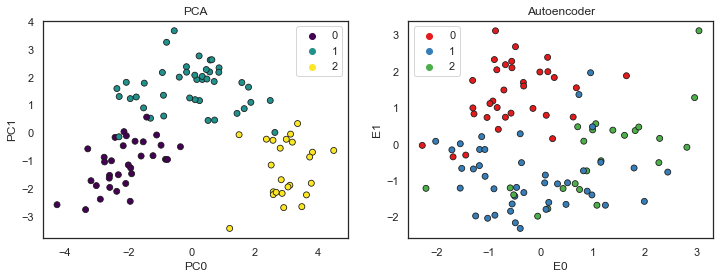

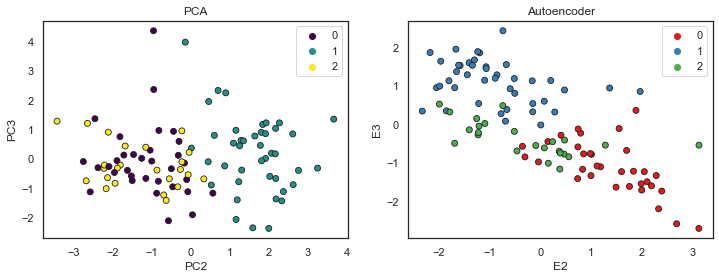

In [287]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 0],
                y=scores[:, 1],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC0')
plt.ylabel('PC1')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.xlabel('E0')
plt.ylabel('E1')
plt.title('Autoencoder')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 1],
                y=scores[:, 2],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 1],
                y=codings[:, 2],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.title('Autoencoder')
plt.xlabel('E2')
plt.ylabel('E3');

The figure above compares the PCA (left) and Autoencoder (right) algorithms. Autoencoder graphics are the same as the previous item. The PCA graphs did not change in relation to the previous item (3 dimensions), and therefore present more defined clusters, in relation to the Autoencoder graphs.

In [288]:
scores_train = pca.transform(X_tr_std)
scores_test = pca.transform(X_test_std)

codings_train = encoder.predict(X_tr_std)
codings_test = encoder.predict(X_test_std)

2/2 [==============================] - 0s 6ms/step


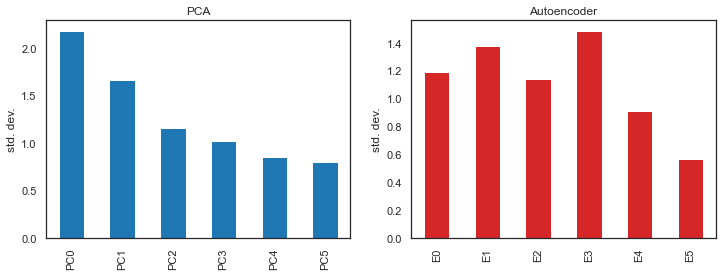

In [289]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
c = ['PC' + str(i) for i in range(ldim)]
pd.DataFrame(scores_train, columns=c).std().plot(kind='bar', color='tab:blue')
plt.title('PCA')
plt.ylabel('std. dev.')

plt.subplot(1, 2, 2)
c2 = ['E' + str(i) for i in range(ldim)]
pd.DataFrame(codings_train, columns=c2).std().plot(kind='bar', color='tab:red')
plt.title('Autoencoder')
plt.ylabel('std. dev.');

The graphs above show the standard deviation for PCA and Autoencoder. In the case of the PCA, the behavior is expected, the deviation decreases along the dimensions. In the case of Autoencoder this behavior also happened in the last dimensions, however in most dimensions the deviation is relatively constant.

Correlation map:

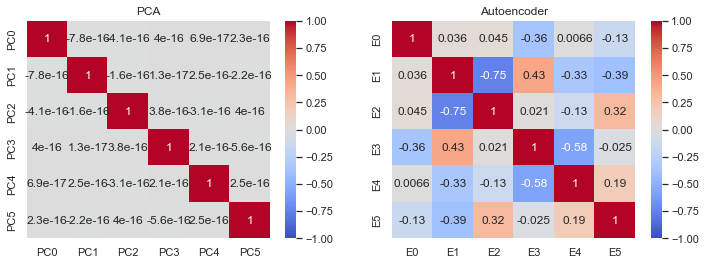

In [290]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(pd.DataFrame(scores_train,
                         columns=[
                             'PC' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('PCA')

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(codings_train,
                         columns=[
                             'E' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('Autoencoder');

The graph on the left relative to the PCA shows that the principal components (PC) are not orthogonal to each other and are not related. The graph on the right, from the Autoencoder, shows that there is a relationship and the neural network behaved as expected.

<hr style="height:10px;border-width:0;background-color:blue">

## 9 latent dimensions

### Autoencoder

An input layer and an output layer with 13 neurons, and an intermediate layer with 9 neurons (9 latent dimensions). The number of input and output neurons (encoder-decoder) corresponds to the number of dimensions of the dataset:

In [291]:
ldim = 9
encoder = keras.models.Sequential(
    [keras.layers.Dense(ldim, input_shape=[X.shape[1]])])
decoder = keras.models.Sequential(
    [keras.layers.Dense(X.shape[1], input_shape=[ldim])])
autoencoder = keras.models.Sequential([encoder, decoder])

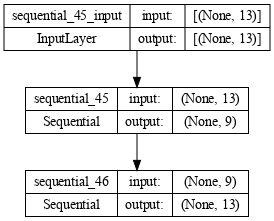

In [292]:
keras.utils.plot_model(autoencoder,
                       show_shapes=True,
                       show_layer_activations=True,
                       dpi=72)

In [293]:
autoencoder.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_45 (Sequential)  (None, 9)                 126       
                                                                 
 sequential_46 (Sequential)  (None, 13)                130       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


In [294]:
autoencoder.compile(loss='mse', optimizer="sgd")

In [295]:
history = autoencoder.fit(
    X_tr_std,
    X_tr_std,
    epochs=300,
    validation_data=(X_valid_std, X_valid_std),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/300
4/4 [==============================] - 0s 36ms/step - loss: 2.0519 - val_loss: 2.0337
Epoch 2/300
4/4 [==============================] - 0s 9ms/step - loss: 1.8421 - val_loss: 1.9409
Epoch 3/300
4/4 [==============================] - 0s 9ms/step - loss: 1.7439 - val_loss: 1.8540
Epoch 4/300
4/4 [==============================] - 0s 9ms/step - loss: 1.6540 - val_loss: 1.7834
Epoch 5/300
4/4 [==============================] - 0s 9ms/step - loss: 1.5789 - val_loss: 1.7119
Epoch 6/300
4/4 [==============================] - 0s 10ms/step - loss: 1.5051 - val_loss: 1.6507
Epoch 7/300
4/4 [==============================] - 0s 9ms/step - loss: 1.4459 - val_loss: 1.5806
Epoch 8/300
4/4 [==============================] - 0s 9ms/step - loss: 1.3640 - val_loss: 1.5252
Epoch 9/300
4/4 [==============================] - 0s 9ms/step - loss: 1.3115 - val_loss: 1.4741
Epoch 10/300
4/4 [==============================] - 0s 9ms/step - loss: 1.2610 - val_loss: 1.4273
Epoch 11/300
4/4 [=========

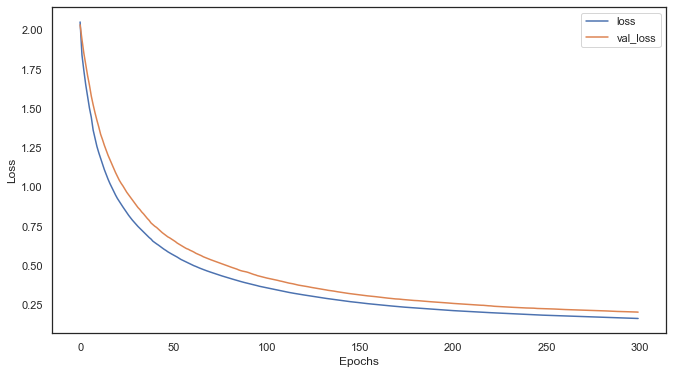

In [296]:
pd.DataFrame(history.history).plot()
plt.ylabel('Loss')
plt.xlabel('Epochs');

The learning curve graph above shows the losses during training and validation. The error during validation closely follows the error during training (around 0.25 for 300 epochs).

In [297]:
codings = encoder.predict(X_tr_std)

4/4 [==============================] - 0s 1ms/step


Scatter chart:

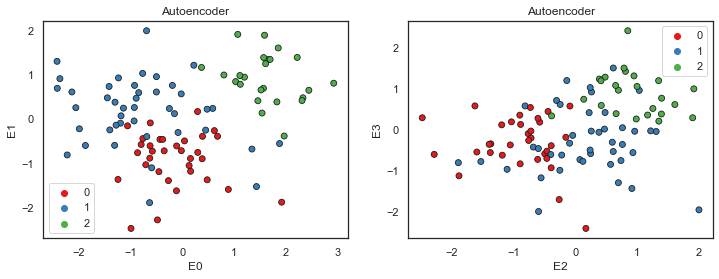

In [298]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E0")
plt.ylabel(f"E1")
plt.title(f"Autoencoder")

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 1],
                y=codings[:, 2],
                hue=y_tr,
                palette="Set1",
                edgecolor='k',
                linewidth=0.8)
plt.xlabel(f"E2")
plt.ylabel(f"E3")
plt.title(f"Autoencoder");

The scatterplots above show the first latent dimensions, taken from the prediction data. The graph axes are two dimensions of the prediction. Compared to the previous item, the clusters are better defined.

### PCA

In [299]:
pca = PCA(n_components=ldim, svd_solver='auto')
scores = pca.fit_transform(X_tr_std)

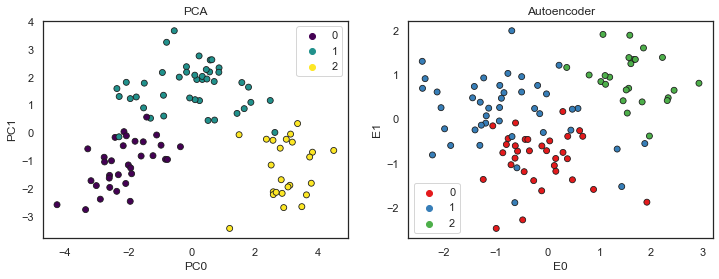

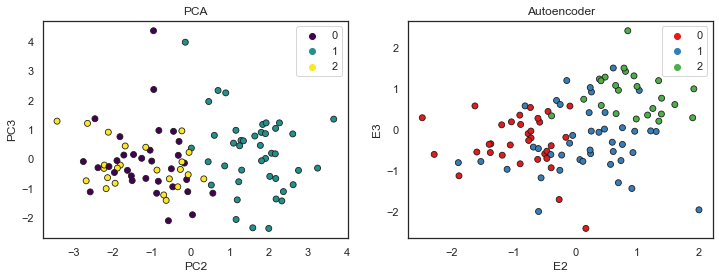

In [300]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 0],
                y=scores[:, 1],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC0')
plt.ylabel('PC1')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 0],
                y=codings[:, 1],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.xlabel('E0')
plt.ylabel('E1')
plt.title('Autoencoder')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.scatterplot(x=scores[:, 1],
                y=scores[:, 2],
                hue=y_tr,
                palette='viridis',
                edgecolor='k',
                linewidth=0.8)
plt.title('PCA')
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(1, 2, 2)
sns.scatterplot(x=codings[:, 1],
                y=codings[:, 2],
                hue=y_tr,
                palette='Set1',
                edgecolor='k',
                linewidth=0.8)
plt.title('Autoencoder')
plt.xlabel('E2')
plt.ylabel('E3');

The figure above compares the PCA (left) and Autoencoder (right) algorithms. Autoencoder graphics are the same as the previous item. The PCA graphics have not changed in relation to the previous item. The comparison shows defined clusters, for both algorithms.

In [302]:
scores_train = pca.transform(X_tr_std)
scores_test = pca.transform(X_test_std)

codings_train = encoder.predict(X_tr_std)
codings_test = encoder.predict(X_test_std)

2/2 [==============================] - 0s 2ms/step


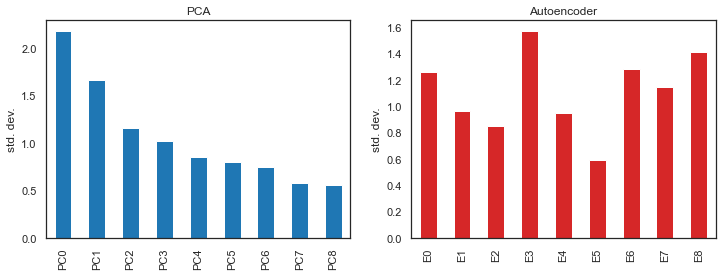

In [303]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
c = ['PC' + str(i) for i in range(ldim)]
pd.DataFrame(scores_train, columns=c).std().plot(kind='bar', color='tab:blue')
plt.title('PCA')
plt.ylabel('std. dev.')

plt.subplot(1, 2, 2)
c2 = ['E' + str(i) for i in range(ldim)]
pd.DataFrame(codings_train, columns=c2).std().plot(kind='bar', color='tab:red')
plt.title('Autoencoder')
plt.ylabel('std. dev.');

The graphs above show the standard deviation for PCA and Autoencoder. In the case of the PCA, the behavior is expected, the deviation decreases along the dimensions. In the case of Autoencoder the deviation is relatively constant.

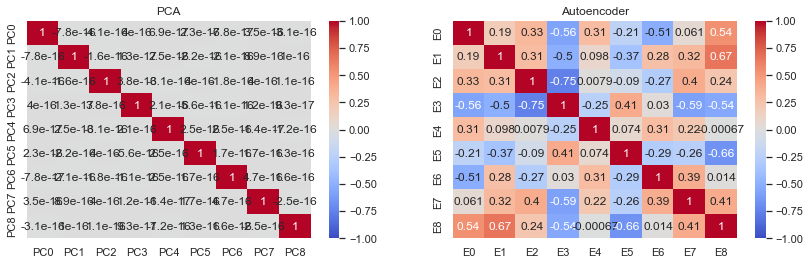

In [304]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.heatmap(pd.DataFrame(scores_train,
                         columns=[
                             'PC' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('PCA')

plt.subplot(1, 2, 2)
sns.heatmap(pd.DataFrame(codings_train,
                         columns=[
                             'E' + str(i) for i in range(pca.n_components_)
                         ]).corr(),
            vmin=-1,
            vmax=+1,
            cmap='coolwarm',
            annot=True)
plt.title('Autoencoder');

The graph on the left relative to the PCA shows that the principal components (PC) are not orthogonal to each other and are not related. The graph on the right, from the Autoencoder, shows that there is a relationship and the neural network behaved as expected.

<hr style="height:10px;border-width:0;background-color:red">

# References

- Notas de aula. CAP-351. Prof. Quiles
- https://github.com/AndC314/LV_PCA_NN/blob/main/VAE.ipynb
- https://towardsdatascience.com/dimensionality-reduction-with-autoencoders-versus-pca-f47666f80743
- https://keras.io/examples/generative/vae/
- https://charlesreid1.github.io/circe/Digit%20Classification%20-%20PCA.html